# **Advanced Lane Lines Project**

[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

## Feature Extraction

### Import handy libraries

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

### Visualize Helper Function

In [3]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dems = len(img.shape)
        if img_dems < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

### HOG Feature Extraction

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### HOG Feature Extraction Testing

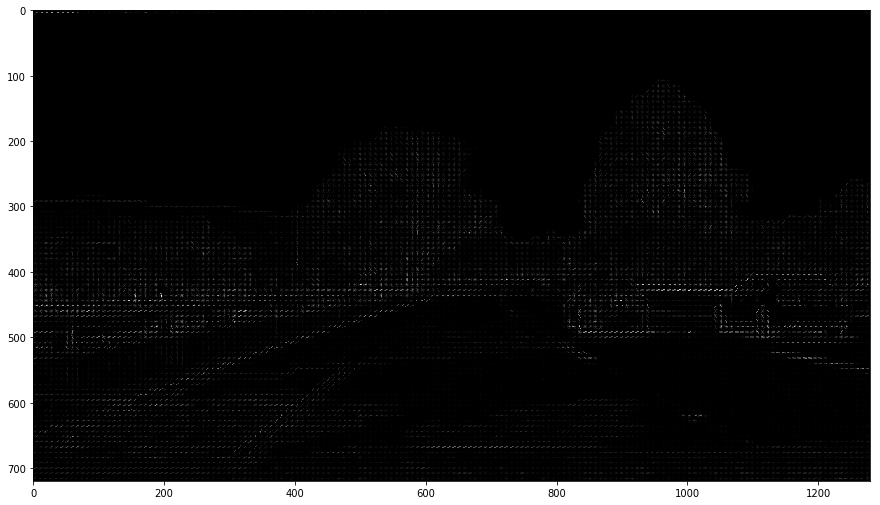

In [5]:
hog_test = cv2.imread('test_images/test4.jpg')
hog_test = cv2.cvtColor(hog_test, cv2.COLOR_BGR2GRAY)
features, hog_img = get_hog_features(hog_test, 9, 8, 2, True)
plt.figure(figsize=(15,15))
plt.imshow(hog_img, cmap='gray')

### Color Based Feature Extraction

In [6]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Color Based Feature Extraction Test

### Space Based Feature Extraction

In [7]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

### Combine Features Extracted

In [8]:
## Extract features for a single img.
## This becomes useful for when we want
## to extract features from multiple images
## or a single window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [9]:
# # Define a function to extract features from a list of images
# # Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Sliding Window Search

In [10]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_overlap=(0.5, 0.5), negative_mining=False):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    if not negative_mining:
        window_intervals = [
            [50,100,150,200],
        ]
        window_list = []
        for interval in window_intervals:
            windows = interval
            
            # Used to track where sliding window is
            # in the y direction
            current_y = y_start_stop[0] - windows[0]*(1-xy_overlap[0])

            for w in windows:
                # Compute the number of pixels per step in x/y
                nx_pix_per_step = np.int(w*(1 - xy_overlap[0]))
                ny_pix_per_step = np.int(w*(1 - xy_overlap[1]))

                # Compute the number of windows in x
                nx_buffer = np.int(w*(xy_overlap[0]))
                nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) + 1

                # Loop through finding x window positions
                for xs in range(nx_windows):
                    # Calculate window position
                    startx = np.int(xs*nx_pix_per_step + x_start_stop[0])
                    endx = np.int(startx + w)
                    starty = np.int(current_y + ny_pix_per_step)
                    endy = np.int(starty + w)

                    # Append window position to list
                    window_list.append(((startx, starty), (endx, endy)))

                current_y += ny_pix_per_step
    else:
        xy_window = [128, 128]
        
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]

                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        
    # Return the list of windows
    return window_list

### Search Through Windows

In [11]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        decision = clf.decision_function(test_features)
        if 0.3 < decision:
            on_windows.append(window)
#         prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
#         if prediction == 1:
#             on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Draw Boxes

In [134]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_labeled_bboxes(img, labels, d_threshold=50):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        if bbox[1][0]-bbox[0][0] >= d_threshold and bbox[1][1]-bbox[0][1] >= d_threshold:
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Read In Car and Non-car Images

In [13]:
import os

# Read in cars and notcars
car_names = glob.glob('vehicles/*/*.png')
non_car_names = glob.glob('non-vehicles/*/*.png')
cars = []
notcars = []
for name in car_names:
    cars.append(mpimg.imread(name))
for name in non_car_names:
    notcars.append(mpimg.imread(name))
    
print('Number of car images', len(cars))
print('Number of noncar images', len(notcars))

Number of car images 8792
Number of noncar images 9304


## Classifier Pipeline!

### Get car and notcar feature sets

In [14]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 650] # Min and max in y to search in slide_window()

t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2=time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

98.96 Seconds to extract features...


In [15]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
20.63 Seconds to train SVC...
Test Accuracy of SVC =  0.9884


In [16]:
def convert_color(img, conv="RGB2YCrCb"):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

### Use Heatmap + Threshold to eliminate false positives/dupes

In [119]:
dim_heat_threshold = 50

In [130]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        print(abs(box[1][0] - box[0][0]))
        print(abs(box[1][1] - box[0][1]))
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [164]:
x_start = 650
y_start = 400
y_stop = 656
scales = [1.5,1.75,2.0]
window = 64

0.3143880367279053 seconds to run, total windows =  192
0.3712329864501953 seconds to run, total windows =  192
0.36354517936706543 seconds to run, total windows =  192
0.36768603324890137 seconds to run, total windows =  192
0.34052395820617676 seconds to run, total windows =  192
0.32898688316345215 seconds to run, total windows =  192


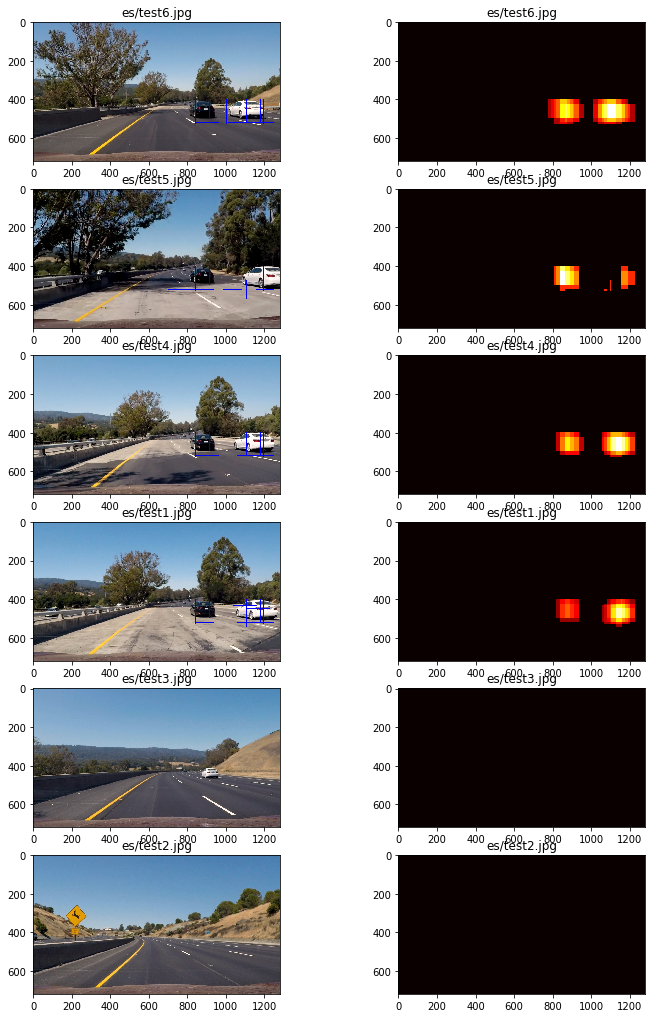

In [55]:
test_images = glob.glob('test_images/*')

out_images = []
out_maps = []
out_titles = []
out_boxes = []

for img_name in test_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_name)
    draw_img = np.copy(img)
    
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    for scale in scales:
        img_tosearch = img[y_start:y_stop,x_start:img.shape[1],:]
        cvt_img = convert_color(img_tosearch)

        if scale != 1:
            shape = cvt_img.shape
            cvt_img = cv2.resize(cvt_img, (np.int(shape[1]/scale), np.int(shape[0]/scale)))

        ch1 = cvt_img[:,:,0]
        ch2 = cvt_img[:,:,1]
        ch3 = cvt_img[:,:,2]

        nx_blocks = (ch1.shape[1] // pix_per_cell) - 1
        ny_blocks = (ch1.shape[0] // pix_per_cell) - 1
        n_feat_per_block = orient*cell_per_block**2
        blocks_per_window = (window // pix_per_cell) - 1
        cells_per_step = 2
        nx_steps = (nx_blocks - blocks_per_window) // cells_per_step
        ny_steps = (ny_blocks - blocks_per_window) // cells_per_step

        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)    
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)    

        for xb in range(nx_steps):
            for yb in range(ny_steps):
                count += 1
                x_pos = xb*cells_per_step
                y_pos = yb*cells_per_step

                hog_f1 = hog1[
                    y_pos:y_pos+blocks_per_window,
                    x_pos:x_pos+blocks_per_window
                ].ravel()
                hog_f2 = hog2[
                    y_pos:y_pos+blocks_per_window,
                    x_pos:x_pos+blocks_per_window
                ].ravel()
                hog_f3 = hog3[
                    y_pos:y_pos+blocks_per_window,
                    x_pos:x_pos+blocks_per_window
                ].ravel()
                hog_features = np.hstack((hog_f1, hog_f2, hog_f3))

                x_left = x_pos*pix_per_cell
                y_top = y_pos*pix_per_cell

                sub_img = cv2.resize(cvt_img[y_top:y_top+window,x_left:x_left+window], (window, window))

                spatial_features = bin_spatial(sub_img, size=spatial_size)
                hist_features = color_hist(sub_img, nbins=hist_bins)

                test_features = X_scaler.transform(
                    np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                test_pred = svc.predict(test_features)

                if test_pred == 1:
                    x_box_l = np.int(x_left*scale)
                    y_top_draw = np.int(y_top*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(
                        draw_img,
                        (x_start+x_box_l, y_top_draw+y_start),
                        (x_start+x_box_l+win_draw,y_top_draw+win_draw+y_start),
                        (0,0,255))
                    img_boxes.append((
                        (x_start+x_box_l, y_top_draw+y_start),
                        (x_start+x_box_l+win_draw,y_top_draw+win_draw+y_start)))
                    heatmap[
                        y_top_draw+y_start:y_top_draw+win_draw+y_start,
                        x_start+x_box_l:x_start+x_box_l+win_draw] += 1
                
    print(time.time()-t, 'seconds to run, total windows = ', count)

    out_images.append(draw_img)

    out_titles.append(img_name[-12:])
    out_titles.append(img_name[-12:])
    
    heatmap = apply_threshold(heatmap, 2)
    
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
        
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

### Hog subsampling pipeline

In [77]:
class Helper:
    heatmap = []
    heat_buffer = []

In [180]:
def subsamp_process_image(img):
    out_images = []
    out_maps = []
    out_titles = []
    out_boxes = []

    img_boxes = []
    count = 0
    draw_img = np.copy(img)
    
    current_heatmap = np.zeros_like(img[:,:,0])
    
    img = img.astype(np.float32)/255
    
    for scale in scales:
        img_tosearch = img[y_start:y_stop,x_start:img.shape[1],:]
        cvt_img = convert_color(img_tosearch)

        if scale != 1:
            shape = cvt_img.shape
            cvt_img = cv2.resize(cvt_img, (np.int(shape[1]/scale), np.int(shape[0]/scale)))

        ch1 = cvt_img[:,:,0]
        ch2 = cvt_img[:,:,1]
        ch3 = cvt_img[:,:,2]

        nx_blocks = (ch1.shape[1] // pix_per_cell) - 1
        ny_blocks = (ch1.shape[0] // pix_per_cell) - 1
        n_feat_per_block = orient*cell_per_block**2
        blocks_per_window = (window // pix_per_cell) - 1
        cells_per_step = 2
        nx_steps = (nx_blocks - blocks_per_window) // cells_per_step
        ny_steps = (ny_blocks - blocks_per_window) // cells_per_step

        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)    
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)    

        for xb in range(nx_steps):
            for yb in range(ny_steps):
                count += 1
                x_pos = xb*cells_per_step
                y_pos = yb*cells_per_step

                hog_f1 = hog1[
                    y_pos:y_pos+blocks_per_window,
                    x_pos:x_pos+blocks_per_window
                ].ravel()
                hog_f2 = hog2[
                    y_pos:y_pos+blocks_per_window,
                    x_pos:x_pos+blocks_per_window
                ].ravel()
                hog_f3 = hog3[
                    y_pos:y_pos+blocks_per_window,
                    x_pos:x_pos+blocks_per_window
                ].ravel()
                hog_features = np.hstack((hog_f1, hog_f2, hog_f3))

                x_left = x_pos*pix_per_cell
                y_top = y_pos*pix_per_cell

                sub_img = cv2.resize(cvt_img[y_top:y_top+window,x_left:x_left+window], (window, window))

                spatial_features = bin_spatial(sub_img, size=spatial_size)
                hist_features = color_hist(sub_img, nbins=hist_bins)

                test_features = X_scaler.transform(
                    np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                test_pred = svc.predict(test_features)

                if test_pred == 1:
                    x_box_l = np.int(x_left*scale)
                    y_top_draw = np.int(y_top*scale)
                    win_draw = np.int(window*scale)
                    current_heatmap[
                        y_top_draw+y_start:y_top_draw+win_draw+y_start,
                        x_start+x_box_l:x_start+x_box_l+win_draw] += 1
                                        
    Helper.heatmap.append(current_heatmap)
                        
    if len(Helper.heatmap) > 5:
        Helper.heatmap.pop(0)
    else:
        return draw_img
        
    output_heatmap = np.zeros_like(img[:,:,0])
        
    for hmap in Helper.heatmap:
        output_heatmap = output_heatmap + hmap
            
    output_heatmap = apply_threshold(output_heatmap, 24)
            
    # Visualize the heatmap when displaying     
    output_heatmap = np.clip(output_heatmap, 0, 255)
    
     # Find final boxes from heatmap using label function
    labels = label(output_heatmap)
    return draw_labeled_bboxes(np.copy(draw_img), labels)

### Test with image

In [ ]:
test_image = mpimg.imread('test_images/test3.jpg')
draw_image = np.copy(test_image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
test_image = test_image.astype(np.float32)/255

windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_overlap=(0.7, 0.7))

hot_windows = search_windows(test_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(np.copy(draw_image), labels)
# fig = plt.figure(figsize=(15,15))
# plt.subplot(121)
# plt.imshow(draw_img)
# plt.title('Car Positions')
# plt.subplot(122)
# plt.imshow(heatmap, cmap='hot')
# plt.title('Heat Map')
# fig.tight_layout()

# draw_img = draw_boxes(draw_image, windows, color=(0,0,255), thick=6)
draw_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.figure(figsize=(15,15))
plt.imshow(draw_img)

In [ ]:
frame = 0

def process_image(image):
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, 750], y_start_stop=y_start_stop, xy_overlap=(0.7, 0.7))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return draw_labeled_bboxes(np.copy(draw_image), labels)

### Feed Video

In [181]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4").set_fps(10)
project_clip = clip1.fl_image(subsamp_process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 504/505 [03:39<00:00,  2.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 33s, sys: 6.29 s, total: 3min 40s
Wall time: 3min 40s


In [182]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

### Negative Mining Extraction

In [ ]:
# test_img_names = glob.glob('test_images/*.jpg')

# for name in test_img_names:
#     test_image = mpimg.imread(name)
#     draw_image = np.copy(test_image)

#     # Uncomment the following line if you extracted training
#     # data from .png images (scaled 0 to 1 by mpimg) and the
#     # image you are searching is a .jpg (scaled 0 to 255)
#     test_image = test_image.astype(np.float32)/255

#     windows = slide_window(test_image, x_start_stop=[None, 650], y_start_stop=y_start_stop, 
#                            xy_overlap=(0.7, 0.7), negative_mining=True)

#     for i in range(len(windows)):
#         window = windows[i]
#         image = test_image[window[0][0]:window[1][0], window[0][1]:window[1][1],:]
#         image64 = cv2.resize(image, (0,0), fx=0.5, fy=0.5)
#         mpimg.imsave(
#             'non-vehicles/my-extras/' + name[name.rfind('/'):name.rfind('.')] + 
#             '_image_' + str(i) + '.png', image64
#         )
    
#     print('saving images for test image ', name[name.rfind('/'):name.rfind('.')] + '.')
    
# print('Saved all images!')